## Pandas analysis

In the following a series of exercises is proposed on a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGA's. Each measurement (i.e. each raw) consists of the address of the TDC providing the signal, 'FPGA' and 'TDC_Channel, and the timing information itself, 'ORBIT_CNT', 'BX_COUNTER' and 'TDC_MEAS'. Each TDC count correspond 25/30 ns, whereas the BX_COUNTER feauters gets updated every 25 ns and the ORBIT_CNT every 'x' BX_COUNTER. You can see these way of storing the time as similar to hours, minutes and seconds.

1\. Create a Pandas DataFrame by read N raws of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of raws and larger that 10k.

2\. Find out the value of 'x'

3\. Find out how much the data taking lasted. You can either make an estimate on the baseis of the fraction of the measurements (raws) you read, or perform this check precisely by reading out the whole dataset

4\. Create a new column with the actual time in ns (as a combination of the other three columns with timing information)

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1

6\. Create a new DataFrame with only the raws with HEAD=1

7\. Make two occupancy plots (one per FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

---

**1)** Create a Pandas DataFrame by read N raws of the 'data_000637.txt' dataset.

Choose N to be smaller than or equal to the maximum number of raws and larger that 10k.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# read all file
filename = os.path.expanduser('~/data/data_000637.txt')
dsFull = pd.read_csv(filename)
#print(len(dsFull))

# extract reduced dataset
# only for showing purposes
# next results use the whole dataset
N = 20000
#ds = dsFull[:N].copy()
ds = dsFull

# split by FPGA (useful later)
ds0 = ds[ ds['FPGA']==0 ]
ds1 = ds[ ds['FPGA']==1 ]

**2)** Find 'x' (here named `bxPerOrbit`).

- Each TDC count is 25/30 ns
- BX_COUNTER gets updated every 25 ns
- ORBIT_CNT every 'x' BX_COUNTER.

In [3]:
# note: this is the only value computed on the full dataset
bxPerOrbit = np.max(dsFull['BX_COUNTER'])+1
print(bxPerOrbit)

3564


**3)** Find out how much the data taking lasted. You can either make an estimate on the baseis of the fraction of the measurements (raws) you read, or perform this check precisely by reading out the whole dataset

In [4]:
omin0 = ds0['ORBIT_CNT'].min() # orbit min and max on both FPGAs
omax0 = ds0['ORBIT_CNT'].max()
omin1 = ds1['ORBIT_CNT'].min()
omax1 = ds1['ORBIT_CNT'].max()

bmin0 = ds0[ ds0['ORBIT_CNT']==omin0 ]['BX_COUNTER'].min() # min bx of min orbit on FPGA0
bmax0 = ds0[ ds0['ORBIT_CNT']==omax0 ]['BX_COUNTER'].max() # max bx of max orbit on FPGA0
bmin1 = ds1[ ds1['ORBIT_CNT']==omin1 ]['BX_COUNTER'].min() # same for FPGA 1
bmax1 = ds1[ ds1['ORBIT_CNT']==omax1 ]['BX_COUNTER'].max()

tmin0 = ds0['TDC_MEAS'].min() # quite an approximation, but trying
tmax0 = ds0['TDC_MEAS'].max() # not to over-complicate the computation
tmin1 = ds1['TDC_MEAS'].min()
tmax1 = ds1['TDC_MEAS'].max()

delta0 = (omax0*bxPerOrbit*25 + bmax0*25 + tmax0*25/30) - \
         (omin0*bxPerOrbit*25 + bmin0*25 + tmin0*25/30) # difference (last - first)
delta1 = (omax1*bxPerOrbit*25 + bmax1*25 + tmax1*25/30) - \
         (omin1*bxPerOrbit*25 + bmin1*25 + tmin1*25/30)
print(delta0)
print(delta1)

980416299.188
980405874.188


**4)** Create a new column with the actual time in ns (as a combination of the other three columns with timing information)

In [5]:
ds['TIME'] = ds['ORBIT_CNT']*bxPerOrbit*30 + ds['BX_COUNTER']*30 + ds['TDC_MEAS']*25/30
# ds

**5)** Replace the values (all 1) of the HEAD column randomly with 0 or 1

In [6]:
ds['HEAD'] = np.random.randint(0,2, len(ds['HEAD']))
# ds

**6)** Create a new DataFrame with only the raws with HEAD=1

In [7]:
dsH1 = ds[ ds['HEAD']==1 ].copy()
# dsH1

**7)** Make two occupancy plots (one per FPGA), i.e. plot the number of counts per TDC channel

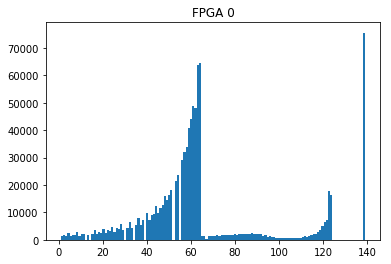

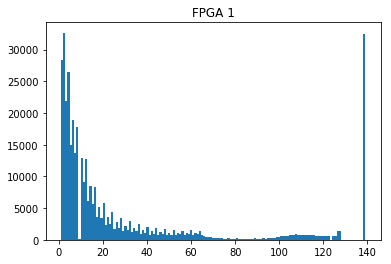

In [8]:
# get max number of channels = number of "bins" of the histogram
max_tdc_channel = ds['TDC_CHANNEL'].max()

plt.hist(ds0['TDC_CHANNEL'], bins=max_tdc_channel)
plt.title("FPGA 0")
plt.show()

plt.hist(ds1['TDC_CHANNEL'], bins=max_tdc_channel)
plt.title("FPGA 1")
plt.show()

**8)** Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

In [9]:
HOWMANY = 5

# group by channel, keep only one column
# count occurrencies, sort by values
# get last indexes (from their column), reverse
group0 = ds0.groupby('TDC_CHANNEL')['HEAD']
count0 = group0.count().sort_values()
noisy0 = list(count0.index[-HOWMANY:])
print("Most noisy channels on FPGA0:", noisy0[::-1])

group1 = ds1.groupby('TDC_CHANNEL')['HEAD']
count1 = group1.count().sort_values()
noisy1 = list(count1.index[-HOWMANY:])
print("Most noisy channels on FPGA1:", noisy1[::-1])

# list() is used only for displaying reasons: it is an array of Int64Index
# not automatically casted to list(int), and print() outputs a lot of clutter

Most noisy channels on FPGA0: [139, 64, 63, 61, 62]
Most noisy channels on FPGA1: [2, 139, 1, 4, 3]


**9)** Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139


In [10]:
unique0 = len(ds0['ORBIT_CNT'].unique())
unique1 = len(ds1['ORBIT_CNT'].unique())
uniqueT = len(ds ['ORBIT_CNT'].unique())

unique0h = len(ds0[ ds0['TDC_CHANNEL']==139 ]['ORBIT_CNT'].unique())
unique1h = len(ds1[ ds1['TDC_CHANNEL']==139 ]['ORBIT_CNT'].unique())
uniqueTh = len(ds [ ds ['TDC_CHANNEL']==139 ]['ORBIT_CNT'].unique())

print("Unique orbits per FPGA = {}, {}".format(unique0, unique1))
print("With at least one meas. from channel 139 = {}, {}".format(unique0h, unique1h))

print("\nNot splitting dataset by FPGAs:\nUnique orbits = {}".format(uniqueT))
print("With at least one meas. from channel 139 = {}".format(uniqueTh))

Unique orbits per FPGA = 11001, 10984
With at least one meas. from channel 139 = 10961, 10381

Not splitting dataset by FPGAs:
Unique orbits = 11001
With at least one meas. from channel 139 = 10976
